In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, PoissonRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, r2_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Load CSV
df = pd.read_csv('california water system.csv')


In [3]:
# Parse survey date
df['SNSV_Visit_Date'] = pd.to_datetime(
    df['Date of Sanitary Survey visit (SNSV Visit Date)'],
    format='%m/%d/%Y',
    errors='coerce'
)

# Numeric conversions
num_cols = [
    'Residential Population',
    'Non-Transient Population',
    'Transient Population',
    'Total Population',
    'Number of Agricultural Service Connections (AG)',
    'Number of Combined Service Connections (CB)',
    'Number of Commercial Service Connections (CM)',
    'Number of Institutional Service Connections (IN)',
    'Number of Residential Service Connections (RS)',
    'Total Number of Service Connections'
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Missing‐value flags
for c in num_cols + ['SNSV_Visit_Date']:
    df[f'{c}_missing'] = df[c].isna()

# Feature engineering
df['connections_per_capita'] = (
    df['Total Number of Service Connections'] /
    df['Total Population']
)
df['transient_to_residential_ratio'] = (
    df['Transient Population'] /
    df['Residential Population']
)
today = pd.to_datetime('2025-04-28')
df['days_since_last_survey'] = (today - df['SNSV_Visit_Date']).dt.days

#  Median threshold for balanced Status_Label
median_days = df['days_since_last_survey'].median()
print(f"Median days since survey = {median_days:.0f}")
df['Status_Label'] = df['days_since_last_survey'].apply(
    lambda x: 'Active' if x <= median_days else 'Inactive'
)

#  Check distribution
print(df['Status_Label'].value_counts())

df.info()

Median days since survey = 1069
Status_Label
Inactive    4120
Active      3695
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7815 entries, 0 to 7814
Data columns (total 51 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   FOB                                                       7815 non-null   object        
 1   Region                                                    7815 non-null   object        
 2   Regulating Agency                                         7815 non-null   object        
 3   Water System No                                           7815 non-null   object        
 4   Water System Name                                         7815 non-null   object        
 5   Principal County Served                                   7815 non-null   object        
 6   Principal County Served, State 

FOB                                                                 object
Region                                                              object
Regulating Agency                                                   object
Water System No                                                     object
Water System Name                                                   object
Principal County Served                                             object
Principal County Served, State                                      object
Federal Water System Type CODE                                      object
Federal Water System Type                                           object
State Water System Type CODE                                        object
State Water System Type                                             object
Water System Status CODE                                            object
System Status                                                       object
Owner Type CODE          

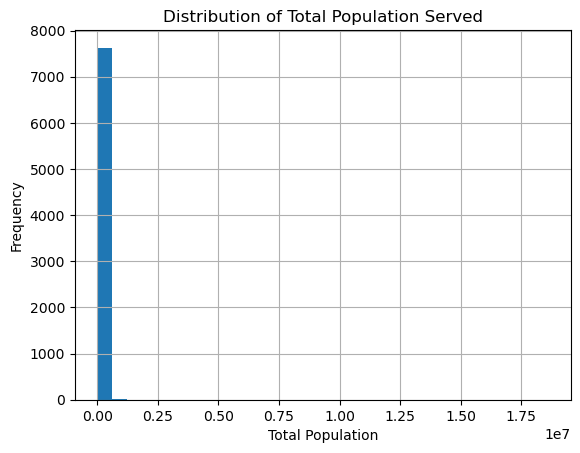

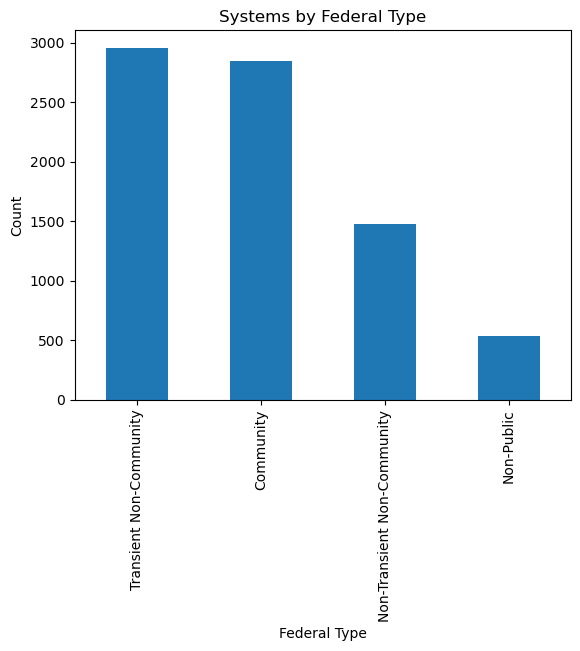

In [4]:
# Basic EDA
# Structure & missing
print(df.dtypes)
print(df.isna().sum())

# Descriptive stats
print(df[num_cols + [
    'connections_per_capita',
    'transient_to_residential_ratio',
    'days_since_last_survey'
]].describe())

# Histogram: Total Population
plt.figure()
df['Total Population'].hist(bins=30)
plt.title('Distribution of Total Population Served')
plt.xlabel('Total Population')
plt.ylabel('Frequency')
plt.show()

# Bar: Federal Water System Type
plt.figure()
df['Federal Water System Type'].value_counts().plot(kind='bar')
plt.title('Systems by Federal Type')
plt.xlabel('Federal Type')
plt.ylabel('Count')
plt.show()


                                                 count    percent
Number of Combined Service Connections (CB)       7793  99.718490
transient_to_residential_ratio                    6759  86.487524
Non-Transient Population                          5501  70.390275
Transient Population                              4105  52.527191
Residential Population                            4051  51.836212
Treatment Plant Class                             3991  51.068458
Treatment Plant Class CODE                        3991  51.068458
Fee Code Description                              1178  15.073576
Fee Code                                          1103  14.113884
Number of Agricultural Service Connections (AG)    609   7.792706


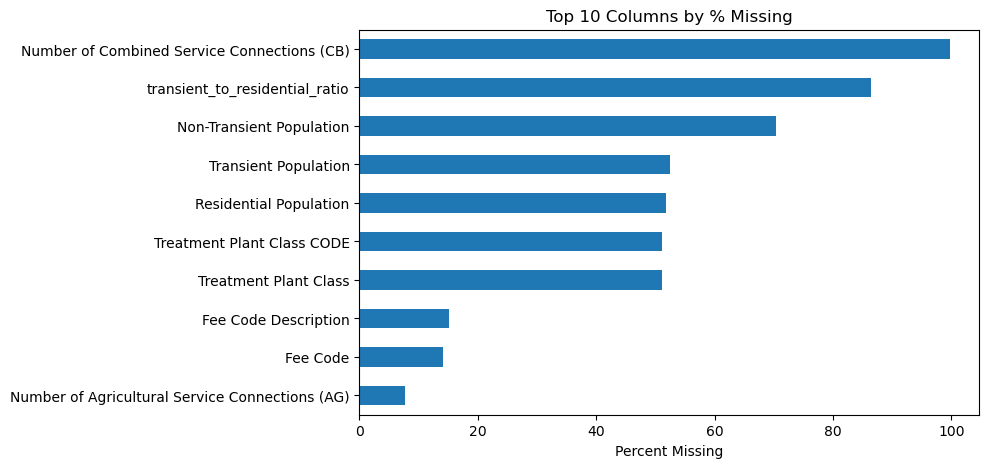

In [5]:
# Missing Data Overview
missing_counts = df.isna().sum()
missing_pct = missing_counts / len(df) * 100
missing_df = pd.DataFrame({'count': missing_counts, 'percent': missing_pct})
missing_df = missing_df.sort_values('percent', ascending=False)
print(missing_df.head(10))

plt.figure(figsize=(8,5))
missing_df['percent'].head(10).sort_values().plot.barh()
plt.title('Top 10 Columns by % Missing')
plt.xlabel('Percent Missing')
plt.show()


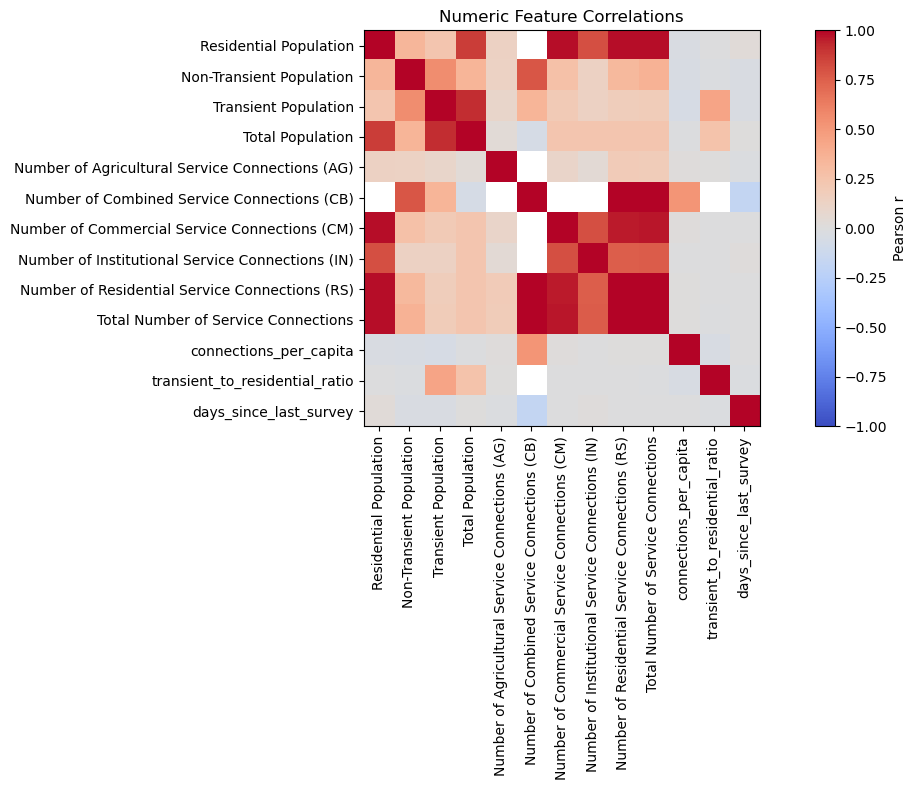

In [6]:
#Correlation Heatmap
corr = df[num_cols + [
    'connections_per_capita',
    'transient_to_residential_ratio',
    'days_since_last_survey'
]].corr()
plt.figure(figsize=(13,8))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Pearson r')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Numeric Feature Correlations')
plt.tight_layout()
plt.show()

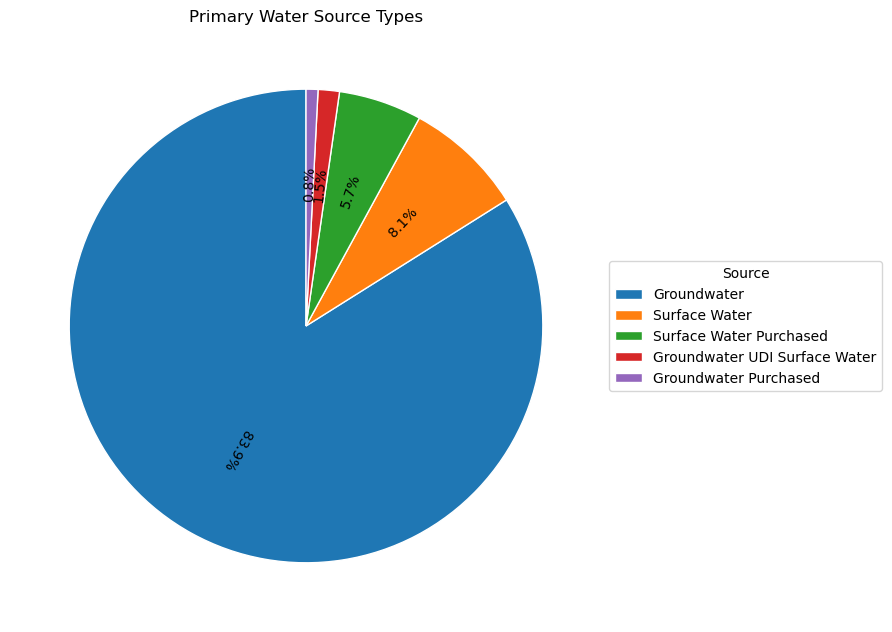

In [7]:
#  Pie: Water Source Breakdown
source_counts = df['Primary Water Source Type'].value_counts()
fig, ax = plt.subplots(figsize=(9,9))
patches, texts, autotexts = ax.pie(
    source_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor':'white'}
)
for autotext, patch in zip(autotexts, patches):
    angle = (patch.theta1 + patch.theta2) / 2
    autotext.set_rotation(angle)
    autotext.set_ha('center')
    autotext.set_va('center')
ax.legend(patches, source_counts.index, title='Source', loc='center left', bbox_to_anchor=(1,0.5))
ax.set_title('Primary Water Source Types')
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

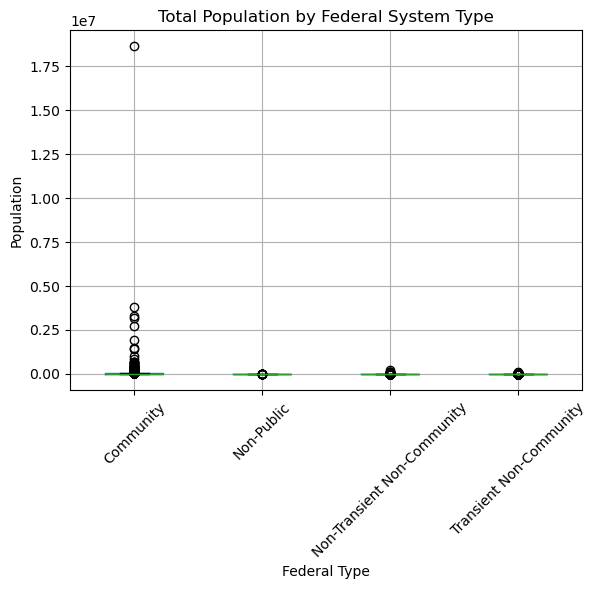

In [8]:
# Box: Population by Federal Type
plt.figure(figsize=(8,5))
df.boxplot(column='Total Population', by='Federal Water System Type', rot=45)
plt.suptitle('')
plt.title('Total Population by Federal System Type')
plt.xlabel('Federal Type')
plt.ylabel('Population')
plt.show()

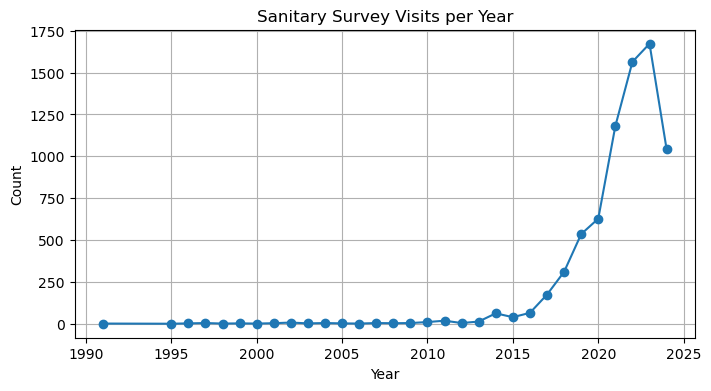

In [9]:
# Time-series: Surveys by Year
survey_year = df['SNSV_Visit_Date'].dt.year.value_counts().sort_index()
plt.figure(figsize=(8,4))
plt.plot(survey_year.index, survey_year.values, marker='o')
plt.title('Sanitary Survey Visits per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.show()

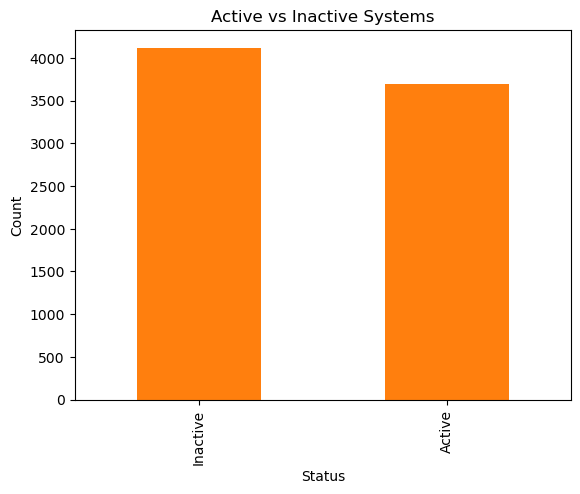

In [10]:
#  Bar: System Status Counts
plt.figure()
df['Status_Label'].value_counts().plot(kind='bar', color='tab:orange')
plt.title('Active vs Inactive Systems')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

<Figure size 800x500 with 0 Axes>

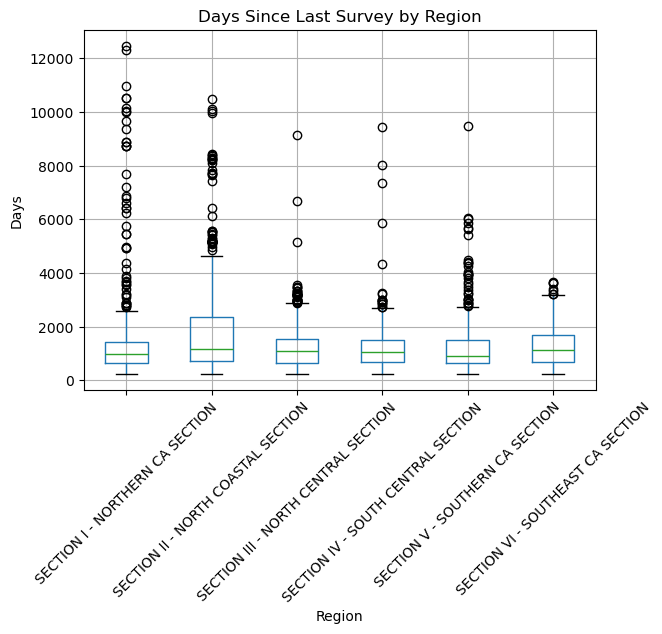

In [11]:
#Box: Days Since Survey by Region
plt.figure(figsize=(8,5))
df.boxplot(column='days_since_last_survey', by='Region', rot=45)
plt.suptitle('')
plt.title('Days Since Last Survey by Region')
plt.xlabel('Region')
plt.ylabel('Days')
plt.show()

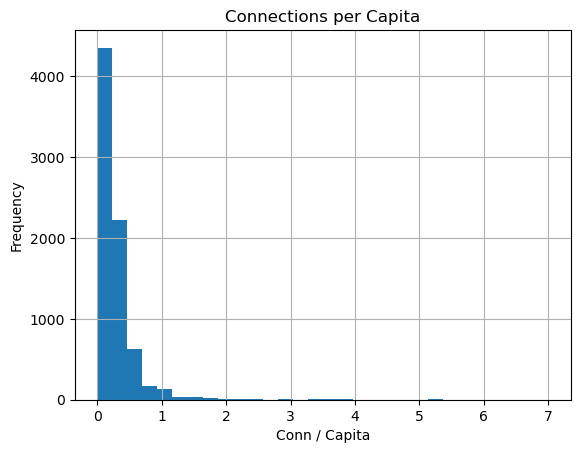

In [12]:
# Histogram: Connections per Capita
plt.figure()
df['connections_per_capita'].hist(bins=30)
plt.title('Connections per Capita')
plt.xlabel('Conn / Capita')
plt.ylabel('Frequency')
plt.show()

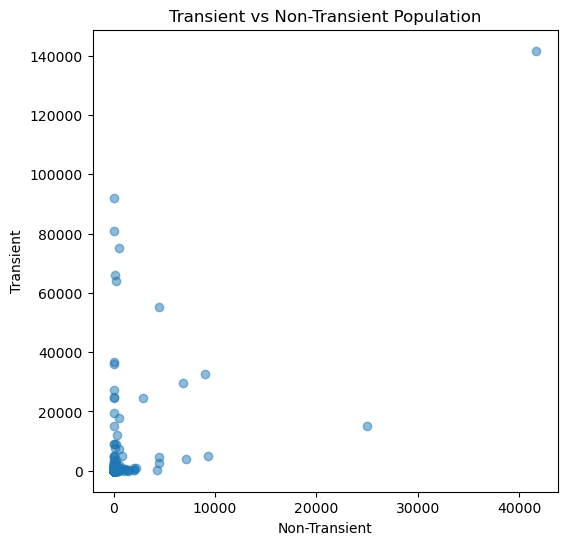

In [13]:
# Scatter: Transient vs Non-Transient Pop
plt.figure(figsize=(6,6))
plt.scatter(df['Non-Transient Population'], df['Transient Population'], alpha=0.5)
plt.title('Transient vs Non-Transient Population')
plt.xlabel('Non-Transient')
plt.ylabel('Transient')
plt.show()

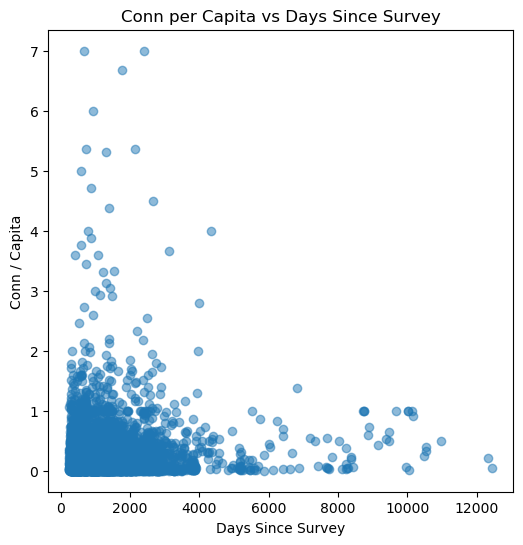

In [14]:
# Scatter: Conn per Capita vs Survey Recency
plt.figure(figsize=(6,6))
plt.scatter(df['days_since_last_survey'], df['connections_per_capita'], alpha=0.5)
plt.title('Conn per Capita vs Days Since Survey')
plt.xlabel('Days Since Survey')
plt.ylabel('Conn / Capita')
plt.show()


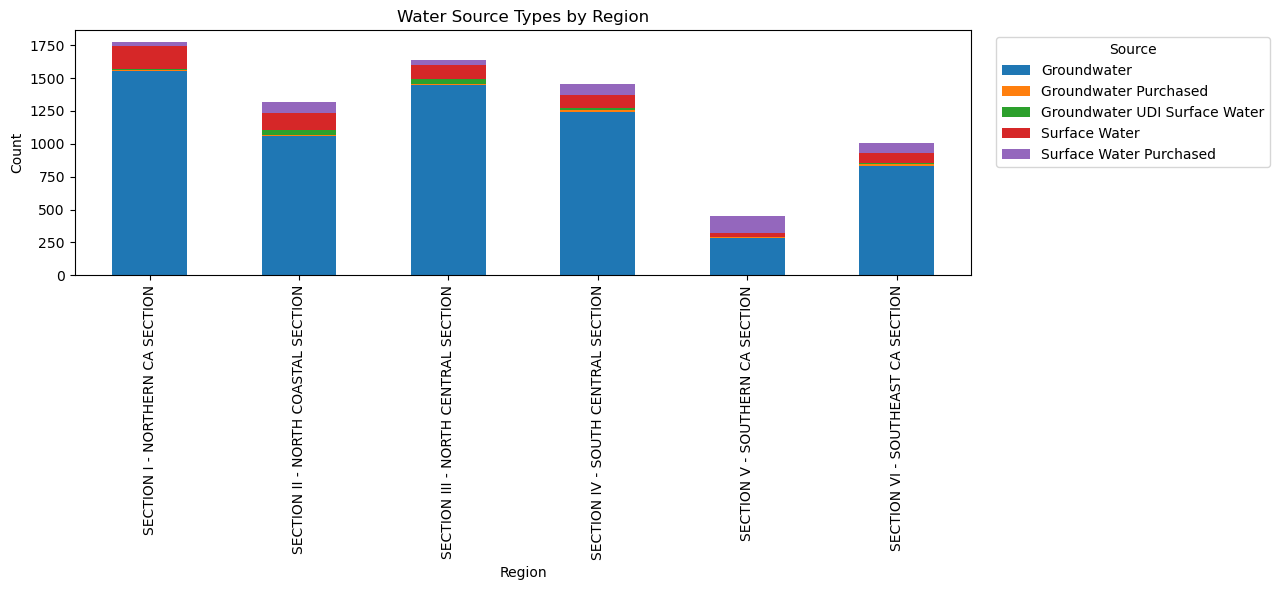

In [15]:
# Stacked Bar: Source by Region
source_by_region = df.groupby(['Region','Primary Water Source Type']).size().unstack(fill_value=0)
source_by_region.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Water Source Types by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Source', bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show()

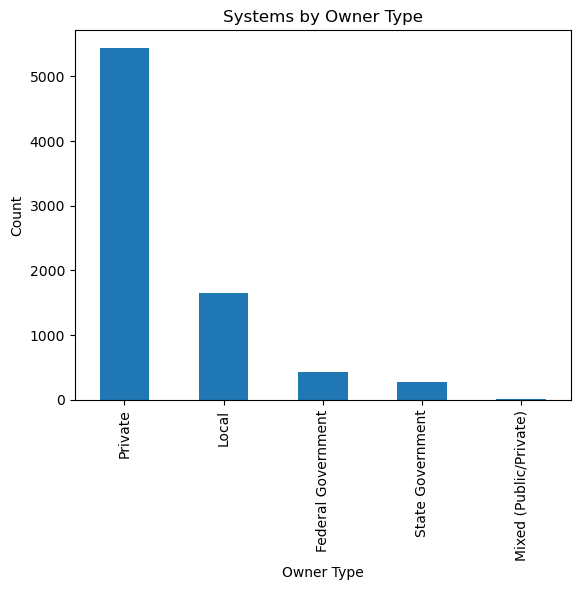

In [16]:
# Bar: Owner Type Counts
plt.figure()
df['Owner Type'].value_counts().plot(kind='bar')
plt.title('Systems by Owner Type')
plt.xlabel('Owner Type')
plt.ylabel('Count')
plt.show()


In [17]:
# Preprocessing & Feature Engineering for Modeling
# Define features
numeric_features = num_cols + [
    'connections_per_capita',
    'transient_to_residential_ratio',
    'days_since_last_survey'
]
categorical_features = [
    'Region',
    'Federal Water System Type',
    'State Water System Type',
    'Owner Type',
    'Primary Water Source Type',
    'Treatment Plant Class',
    'Distribution System Class'
]

# Build pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


=== Logistic Regression ===
Accuracy: 0.982725527831094
              precision    recall  f1-score   support

      Active       0.98      0.99      0.98       739
    Inactive       0.99      0.98      0.98       824

    accuracy                           0.98      1563
   macro avg       0.98      0.98      0.98      1563
weighted avg       0.98      0.98      0.98      1563



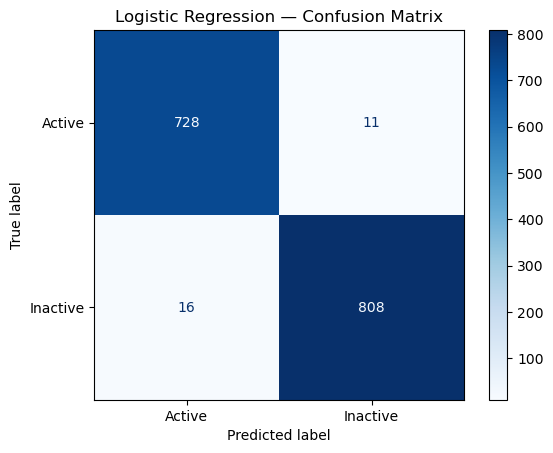

/tmp/ipykernel_35988/3601254467.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


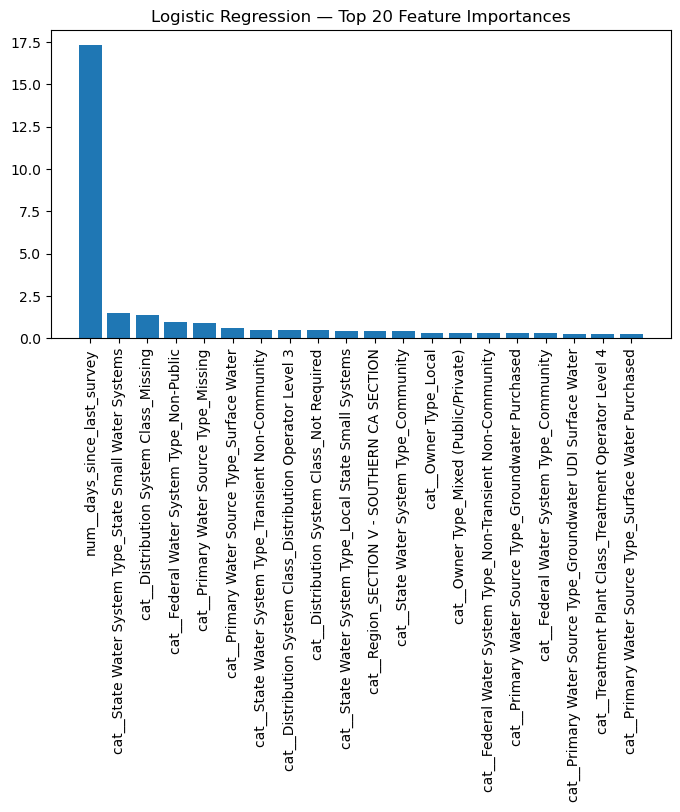

=== Random Forest ===
Accuracy: 1.0
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00       739
    Inactive       1.00      1.00      1.00       824

    accuracy                           1.00      1563
   macro avg       1.00      1.00      1.00      1563
weighted avg       1.00      1.00      1.00      1563



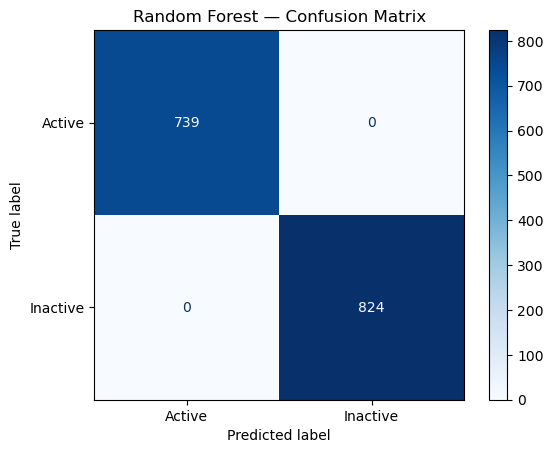

/tmp/ipykernel_35988/3601254467.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


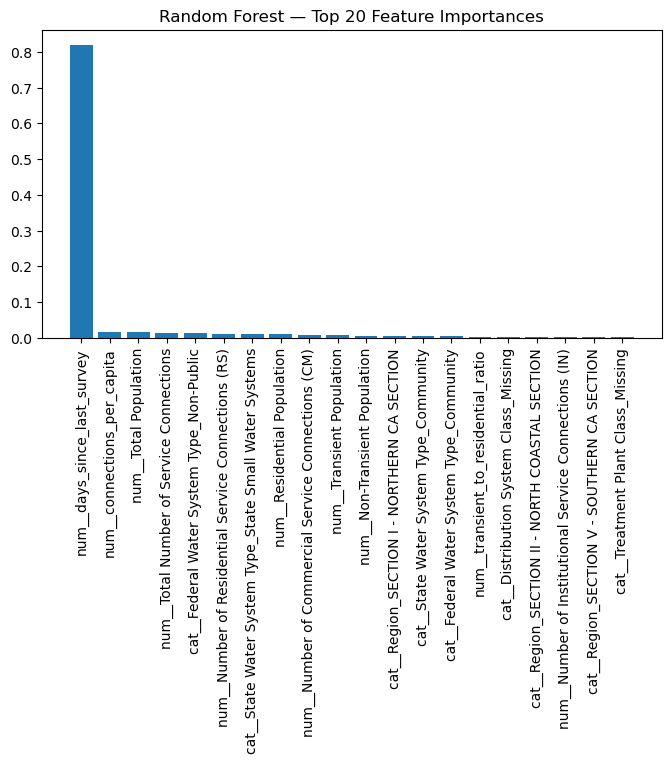

=== Gradient Boosting ===
Accuracy: 1.0
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00       739
    Inactive       1.00      1.00      1.00       824

    accuracy                           1.00      1563
   macro avg       1.00      1.00      1.00      1563
weighted avg       1.00      1.00      1.00      1563



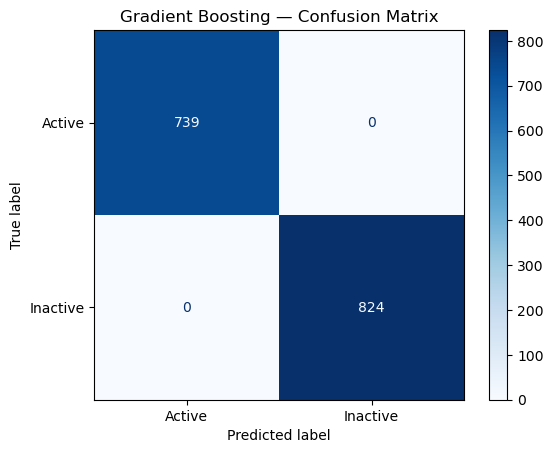

/tmp/ipykernel_35988/3601254467.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


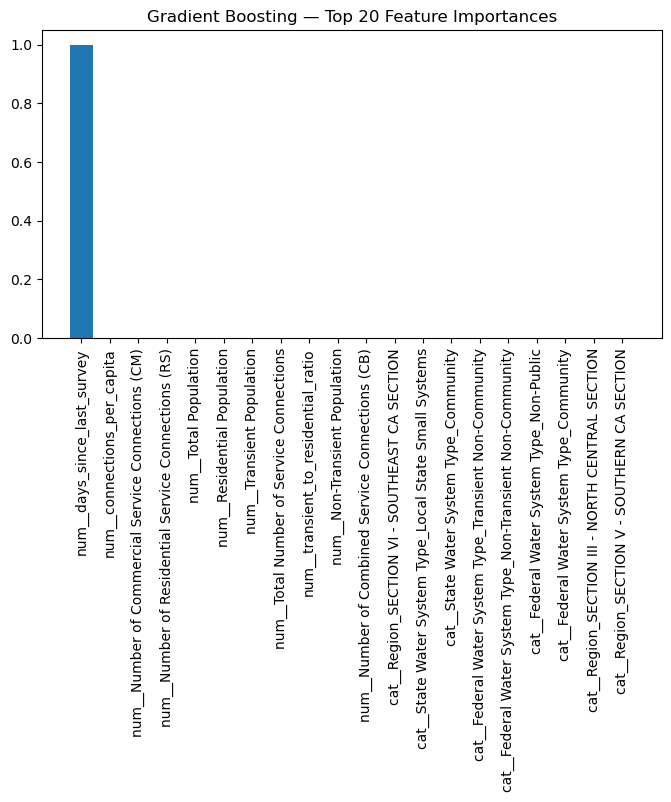

In [18]:
# System Status Prediction with Visuals
# Prepare data

df_status = df.dropna(subset=['Status_Label']).copy()
X = df_status[numeric_features + categorical_features]
y = df_status['Status_Label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

for name, clf in models.items():
    pipe = Pipeline([('prep', preprocessor), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

    # Feature importance / coefficients
    if hasattr(pipe.named_steps['clf'], 'feature_importances_'):
        feat_imp = pipe.named_steps['clf'].feature_importances_
    else:
        # logistic regression: use absolute coef
        coef = pipe.named_steps['clf'].coef_[0]
        feat_imp = np.abs(coef)

    feat_names = pipe.named_steps['prep'].get_feature_names_out()
    idxs = np.argsort(feat_imp)[::-1][:20]   # top 20
    plt.figure(figsize=(8,4))
    plt.bar(np.array(feat_names)[idxs], feat_imp[idxs])
    plt.xticks(rotation=90)
    plt.title(f"{name} — Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()


Population Forecast R²: 0.2877066621085763
Population Forecast MAE: 11761.381245871724


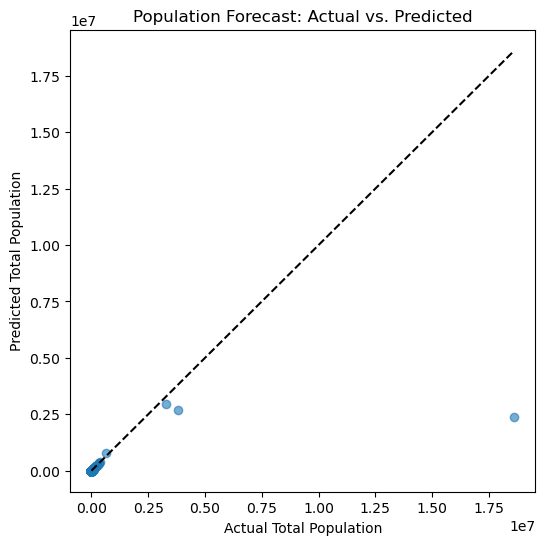

/tmp/ipykernel_35988/666229790.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


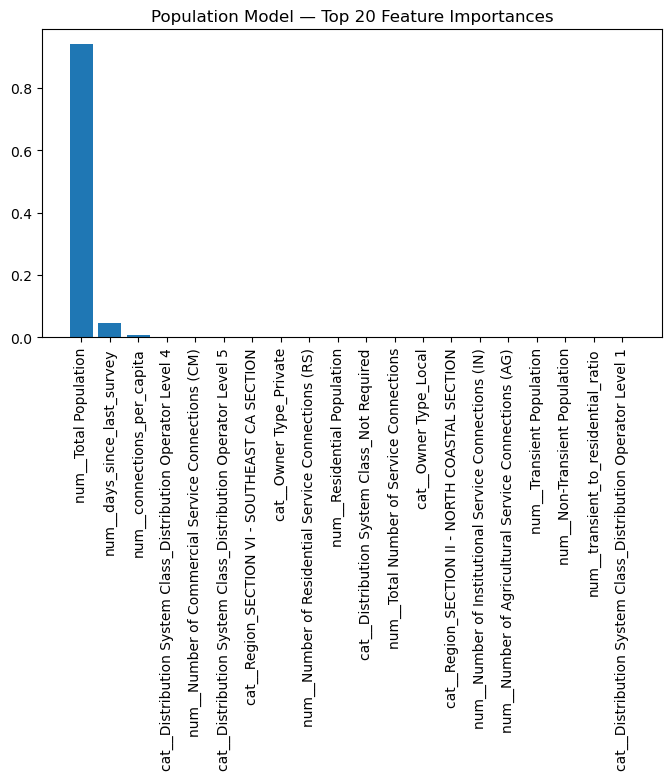

In [19]:
# Population Growth Impact with Predicted vs Actual
# Prepare data
df_pop = df.dropna(subset=['Total Population'])
Xp = df_pop[numeric_features + categorical_features]
yp = df_pop['Total Population']
Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, test_size=0.2, random_state=42)

pop_pipe = Pipeline([('prep', preprocessor),
                     ('reg', GradientBoostingRegressor(random_state=42))])
pop_pipe.fit(Xp_train, yp_train)
yp_pred = pop_pipe.predict(Xp_test)

print("Population Forecast R²:", r2_score(yp_test, yp_pred))
print("Population Forecast MAE:", mean_absolute_error(yp_test, yp_pred))

# Scatter actual vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(yp_test, yp_pred, alpha=0.6)
plt.plot([yp_test.min(), yp_test.max()], [yp_test.min(), yp_test.max()], 'k--')
plt.xlabel('Actual Total Population')
plt.ylabel('Predicted Total Population')
plt.title('Population Forecast: Actual vs. Predicted')
plt.show()

# Feature importance
imp = pop_pipe.named_steps['reg'].feature_importances_
names = pop_pipe.named_steps['prep'].get_feature_names_out()
idxs = np.argsort(imp)[::-1][:20]
plt.figure(figsize=(8,4))
plt.bar(np.array(names)[idxs], imp[idxs])
plt.xticks(rotation=90)
plt.title('Population Model — Top 20 Feature Importances')
plt.tight_layout()
plt.show()


Disadvantaged SC Classification
Accuracy: 0.9494561740243123
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1178
           1       0.88      0.92      0.90       385

    accuracy                           0.95      1563
   macro avg       0.93      0.94      0.93      1563
weighted avg       0.95      0.95      0.95      1563



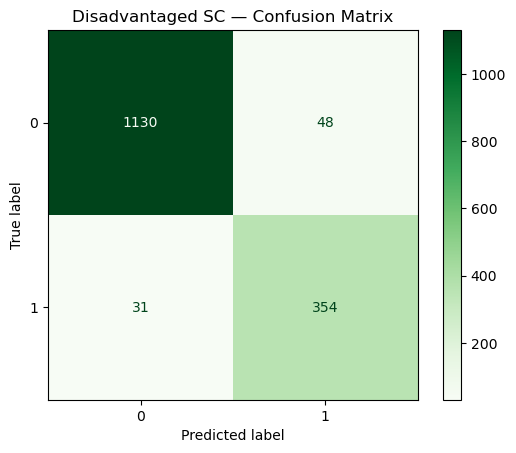

/tmp/ipykernel_35988/3357093370.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


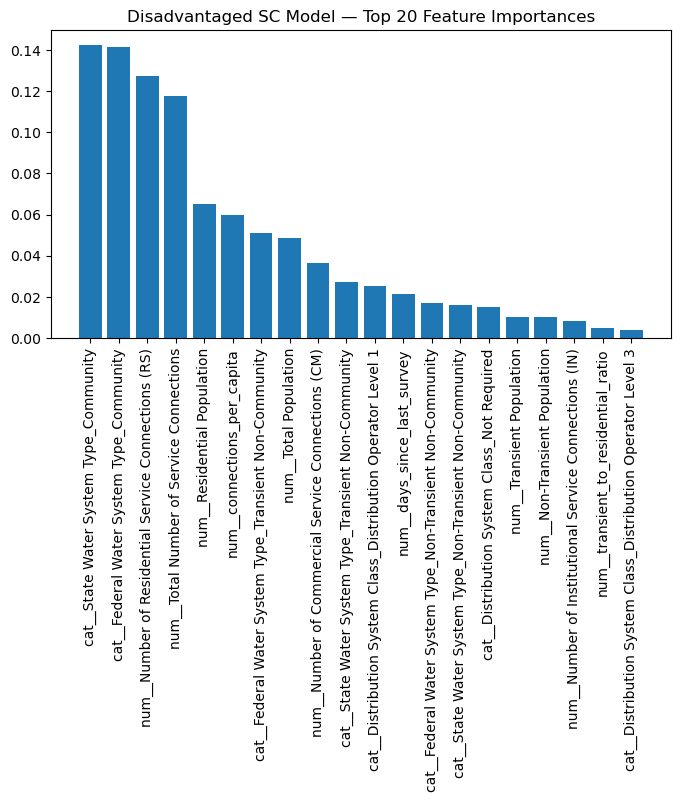

In [20]:
# Disadvantaged Community Identification with Visuals
# Prepare data
df_dc = df.copy()
df_dc['is_small_community'] = (
    df_dc['Fee Code Description'].fillna('').str.contains('Small Community').astype(int)
)
Xdc = df_dc[numeric_features + categorical_features]
ydc = df_dc['is_small_community']
Xdc_train, Xdc_test, ydc_train, ydc_test = train_test_split(
    Xdc, ydc, test_size=0.2, random_state=42, stratify=ydc
)

dc_pipe = Pipeline([('prep', preprocessor),
                    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))])
dc_pipe.fit(Xdc_train, ydc_train)
ydc_pred = dc_pipe.predict(Xdc_test)

print("Disadvantaged SC Classification")
print("Accuracy:", accuracy_score(ydc_test, ydc_pred))
print(classification_report(ydc_test, ydc_pred))

# Confusion Matrix
cm = confusion_matrix(ydc_test, ydc_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(cmap='Greens')
plt.title('Disadvantaged SC — Confusion Matrix')
plt.show()

# Feature Importances
imp = dc_pipe.named_steps['clf'].feature_importances_
names = dc_pipe.named_steps['prep'].get_feature_names_out()
idxs = np.argsort(imp)[::-1][:20]
plt.figure(figsize=(8,4))
plt.bar(np.array(names)[idxs], imp[idxs])
plt.xticks(rotation=90)
plt.title('Disadvantaged SC Model — Top 20 Feature Importances')
plt.tight_layout()
plt.show()


Survey Interval MAE: 345.7058510113458
Survey Interval R²: 0.6987218323477407


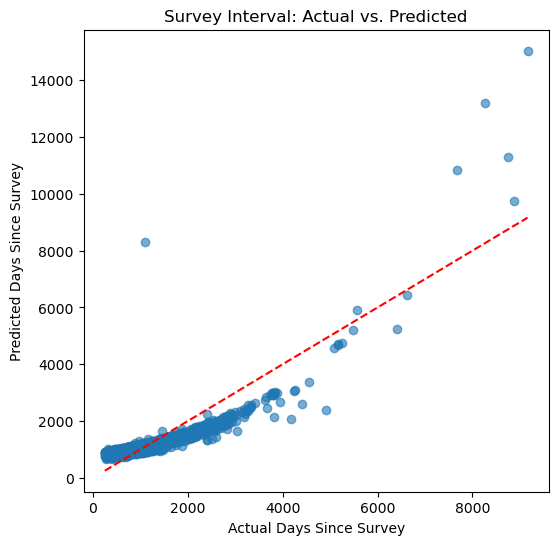

In [21]:
# Sanitary Survey Frequency Prediction with Visuals
# Prepare data
df_ss = df.dropna(subset=['days_since_last_survey'])
Xss = df_ss[numeric_features + categorical_features]
yss = df_ss['days_since_last_survey']
Xss_train, Xss_test, yss_train, yss_test = train_test_split(
    Xss, yss, test_size=0.2, random_state=42
)

ss_pipe = Pipeline([('prep', preprocessor), ('reg', PoissonRegressor(max_iter=1000))])
ss_pipe.fit(Xss_train, yss_train)
yss_pred = ss_pipe.predict(Xss_test)

print("Survey Interval MAE:", mean_absolute_error(yss_test, yss_pred))
print("Survey Interval R²:", r2_score(yss_test, yss_pred))

# Scatter actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(yss_test, yss_pred, alpha=0.6)
plt.plot([yss_test.min(), yss_test.max()], [yss_test.min(), yss_test.max()], 'r--')
plt.xlabel('Actual Days Since Survey')
plt.ylabel('Predicted Days Since Survey')
plt.title('Survey Interval: Actual vs. Predicted')
plt.show()
